EDA - Glovo Orders

-Clarice Mottet

Goal: forecast number of orders for every hour for a week ahead in BCN

Outline:
-Data Checks
-Distribution of order information
-Time dependence (trend, seasonality)
-Serial dependence (cycles)
-Stationarity

In [79]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta

XSMALL_SIZE = 8
SMALL_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 3

plt.rc('font', size=XSMALL_SIZE)           # controls default text sizes\\n\",\n",
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title\\n\",\n",
plt.rc('axes', labelsize=XSMALL_SIZE)    # fontsize of the x and y labels\\n\",\n",
plt.rc('xtick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('ytick', labelsize=XSMALL_SIZE)    # fontsize of the tick labels\\n\",\n",
plt.rc('legend', fontsize=XSMALL_SIZE)    # legend fontsize\\n\",\n",
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title\\n\",\n",
plt.rc('figure', figsize=(7, 2))
plt.rc('figure', dpi=200)

#paths
path_in_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/inputs/'
path_out_ = r'/home/clarice/Documents/VSCode/Term3/Intelligent_Data/IDD_glovo_time_series/outputs/'


#global variables
TARGET = 'orders'

In [84]:
#import data into python

df_orders = pd.read_csv(path_in_ + 'data_BCN.csv', dtype = str)
df_orders['time'] = pd.to_datetime(df_orders['time'])
df_orders['orders'] = pd.to_numeric(df_orders['orders'])

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

## Data Checks

In [81]:
#basic stats - time

df_orders[['time']].describe().T

,count,mean,min,25%,50%,75%,max
time,8766,2021-08-03 01:57:28.459958784,2021-02-01 00:00:00,2021-05-03 13:15:00,2021-08-03 02:30:00,2021-11-02 15:45:00,2022-02-01 23:00:00


Start Time: 2021-02-01
  End Time: 2022-02-01

Data appears to be on hourly level.

In [85]:
#data checks - null, duplicates, missing?

#are there any orders with null information?
print("number of null orders:",df_orders['orders'].isna().sum())

#do we have duplicate order information?
df_view = df_orders.copy()
df_view.drop_duplicates(subset = ['time'], inplace = True)
print("import row count:", len(df_orders['time']))
print("post dup rmv row count:", len(df_view['time']))
del df_view

#are we missing any minute by minute order information?
start_time = pd.to_datetime('2021-02-01')
end_time = pd.to_datetime('2022-02-02')
date_range = pd.date_range(start=start_time, end=end_time, freq='h')
df_all = pd.DataFrame(date_range, columns=['time_all'])

df_all = df_all.merge(df_orders[['time']], how = 'left', left_on = ['time_all'], right_on = ['time'])
print("number of hours missing:",df_all['time'].isna().sum())
df_all_msng = df_all[df_all['time'].isna()].copy()
print("hours missing order information:")
print(df_all_msng)


number of null orders: 0
import row count: 8766
post dup rmv row count: 8766
number of hours missing: 19
hours missing order information:
                time_all time
336  2021-02-15 00:00:00  NaT
337  2021-02-15 01:00:00  NaT
338  2021-02-15 02:00:00  NaT
339  2021-02-15 03:00:00  NaT
340  2021-02-15 04:00:00  NaT
341  2021-02-15 05:00:00  NaT
3024 2021-06-07 00:00:00  NaT
3025 2021-06-07 01:00:00  NaT
3026 2021-06-07 02:00:00  NaT
3027 2021-06-07 03:00:00  NaT
3028 2021-06-07 04:00:00  NaT
3029 2021-06-07 05:00:00  NaT
6216 2021-10-18 00:00:00  NaT
6217 2021-10-18 01:00:00  NaT
6218 2021-10-18 02:00:00  NaT
6219 2021-10-18 03:00:00  NaT
6220 2021-10-18 04:00:00  NaT
6221 2021-10-18 05:00:00  NaT
8784 2022-02-02 00:00:00  NaT


There are 19 hours where we are missing order information taking place over 4 days for multiple consecutive hours.

Just as a placeholder, I'm going to use the average order information but only for data before the point where there is a null value

In [86]:
#add in the hours that the orders data frame is currently missing

#calculate running total of hours in data and orders
df_orders['hours_cumulative'] = 1
df_orders['hours_cumulative'] = df_orders['hours_cumulative'].cumsum()
df_orders['orders_cumulative'] = df_orders['orders'].cumsum()

#merge into the data the missing hours
df_orders = df_all[['time_all']].merge(df_orders, how = 'left', left_on = ['time_all'], right_on = ['time'])
df_orders.sort_values(by = ['time_all'], inplace = True)
df_orders.drop(columns = ['time'], inplace = True)
df_orders.rename(columns = {'time_all':'time'}, inplace = True)

df_orders.sort_values(by = ['time'], inplace = True)
df_orders.reset_index(drop = True, inplace = True)

#fill in the missing hour information with the running average of order information
df_orders['hours_cumulative'] = df_orders['hours_cumulative'].fillna(method = 'ffill')
df_orders['orders_cumulative'] = df_orders['orders_cumulative'].fillna(method = 'ffill')
df_orders.loc[df_orders['orders'].isna(), 'orders'] = (df_orders['orders_cumulative']/df_orders['hours_cumulative']).astype(int)

#check if all orders have order information
print("number of orders missing:",df_orders['orders'].isna().sum())

df_all_msng = df_all_msng.merge(df_orders, how = 'left', on = ['time'])
print(df_all_msng)

## Distribution of Order Information

In [18]:
#general statistics

df_orders[[TARGET]].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
orders,8766.0,73.15,111.04,0.0,0.0,30.0,97.0,939.0


array([[<AxesSubplot:title={'center':'orders'}>]], dtype=object)

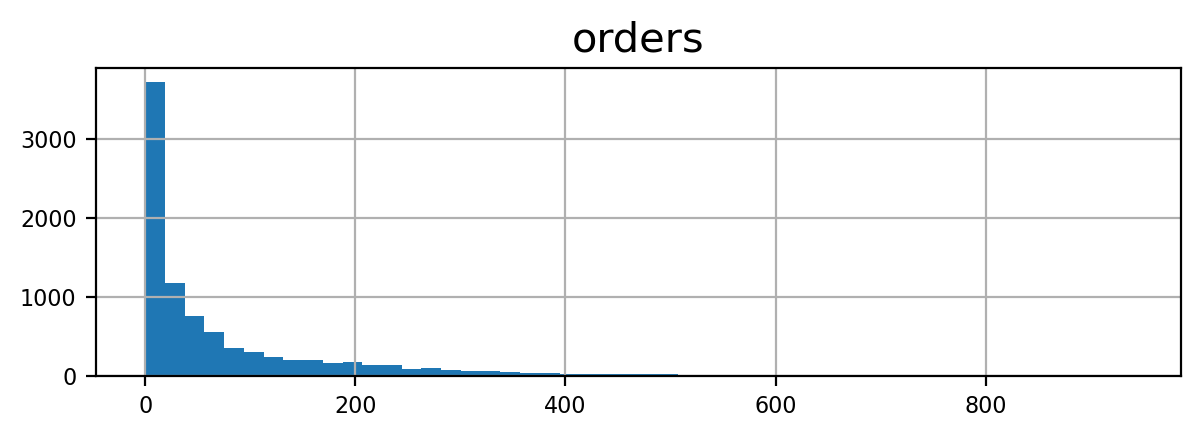

In [30]:
df_orders[[TARGET]].hist(bins=50)

## Evaluate Time Dependence

In [ ]:
#extract out features from time field (hour, day, month, year)

df_orders['year'] = df_orders['time'].dt.year
df_orders['month'] = df_orders['time'].dt.month
df_orders['day'] = df_orders['time'].dt.day
df_orders['hour'] = df_orders['time'].dt.hour
df_orders['minute'] = df_orders['time'].dt.minute
df_orders['dayofweek'] = df_orders['time'].dt.day_of_week
df_orders['dayofyear'] = df_orders['time'].dt.day_of_year